In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import concatenate
from tensorflow.keras.layers import LSTM,Dense,Dropout
from math import *
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

# Data observation

In [2]:
#Import emotiondata
data_input_path = 'E:\\project_data\\tweet_data\\#dogecoin\\report'

filenames = glob.glob(data_input_path + '\\*.csv') # csvs

tempDF = []

for filename in filenames:
    df = pd.read_csv(filename, index_col = None , header = 0)
    tempDF.append(df)

emotiondata = pd.concat(tempDF, axis = 0, ignore_index = True)
emotiondata['date'] = pd.to_datetime(emotiondata['date'])

In [3]:
#Import coindata
coindata= pd.read_csv('E:\\project_data\\coin_data\\DOGE.csv', index_col = None, header = 0)

coindata['time'] = pd.to_datetime(coindata['time'],format='%Y-%m-%d')
coindata['date'] = coindata['time'].dt.date
coindata['date'] = pd.to_datetime(coindata['date'])

In [4]:
#Merge data set
tempData = pd.merge(coindata, emotiondata, on='date')

tempData.index = tempData['date']
tempData=tempData.sort_index()

del tempData['date']
del tempData['time']
del tempData['percent_change_24h']
del tempData['market_cap']
del tempData['volatility']

In [5]:
#Fill NaN
data=tempData.reset_index(drop=False)
data= data.fillna(data.rolling(7,center=True,min_periods=1).mean())
data.index = data['date']
del data['date']

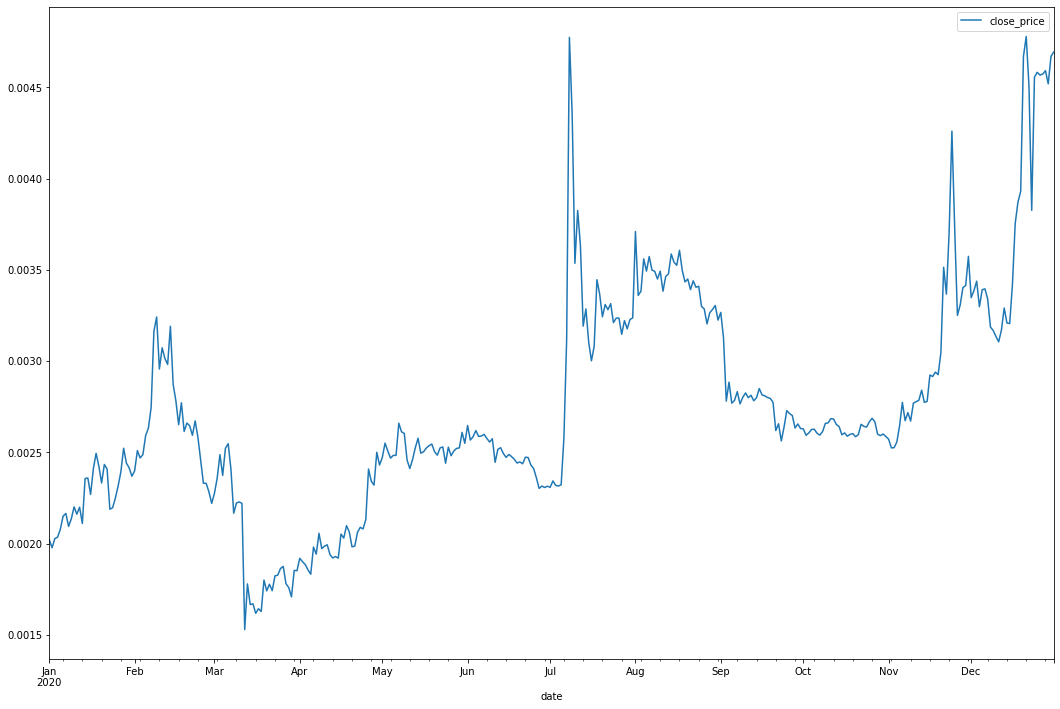

In [6]:
#Time series chart of closing price
price=pd.Series(data['close_price'])
price.plot(figsize=(18,12),label='close_price')

plt.legend() 

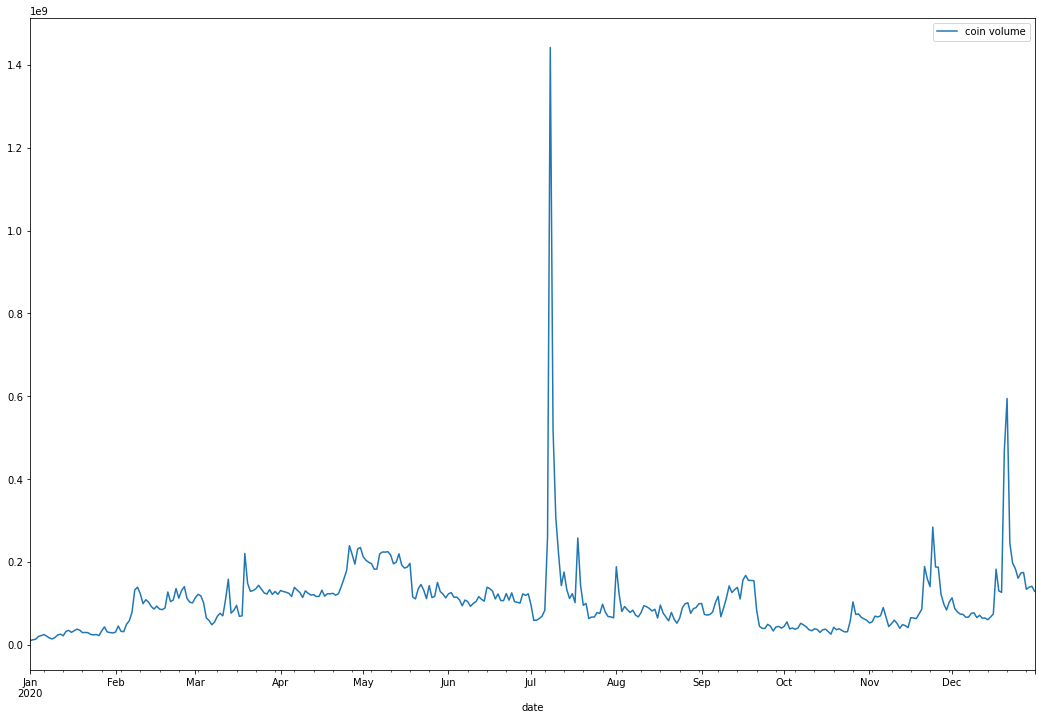

In [7]:
#Time series chart of coin volume
coin_volume=pd.Series(data['volume_24h'])
coin_volume.plot(figsize=(18,12),label='coin volume')

plt.legend() 

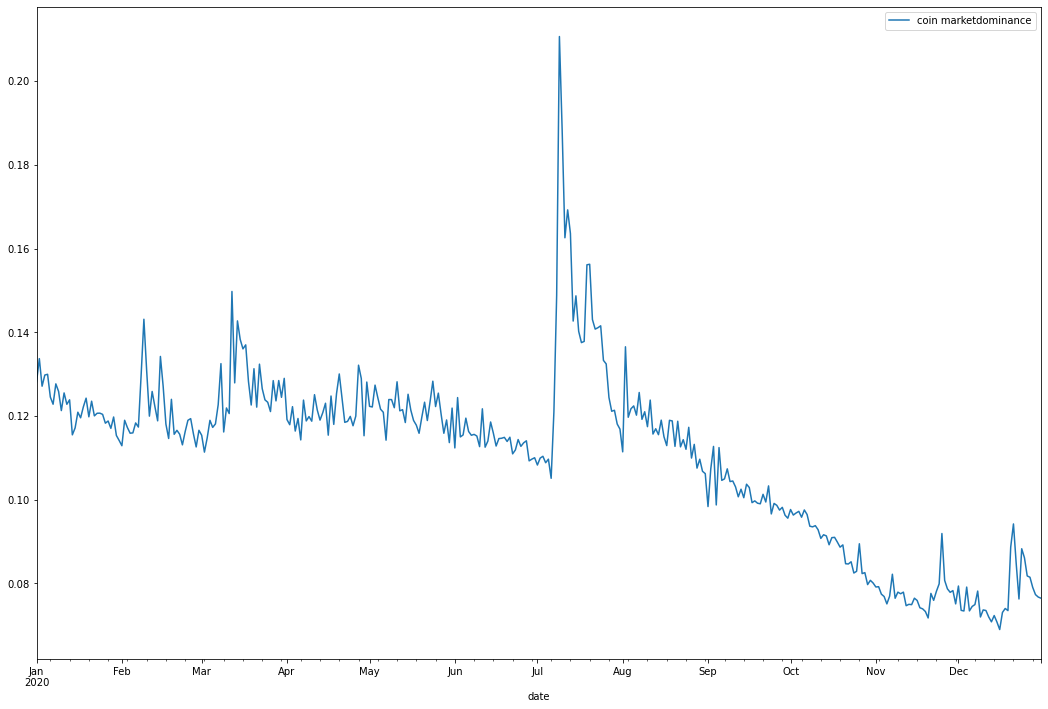

In [8]:
#Time series chart of market dominance
market_dominance=pd.Series(data['market_dominance'])
market_dominance.plot(figsize=(18,12),label='coin marketdominance')

plt.legend() 

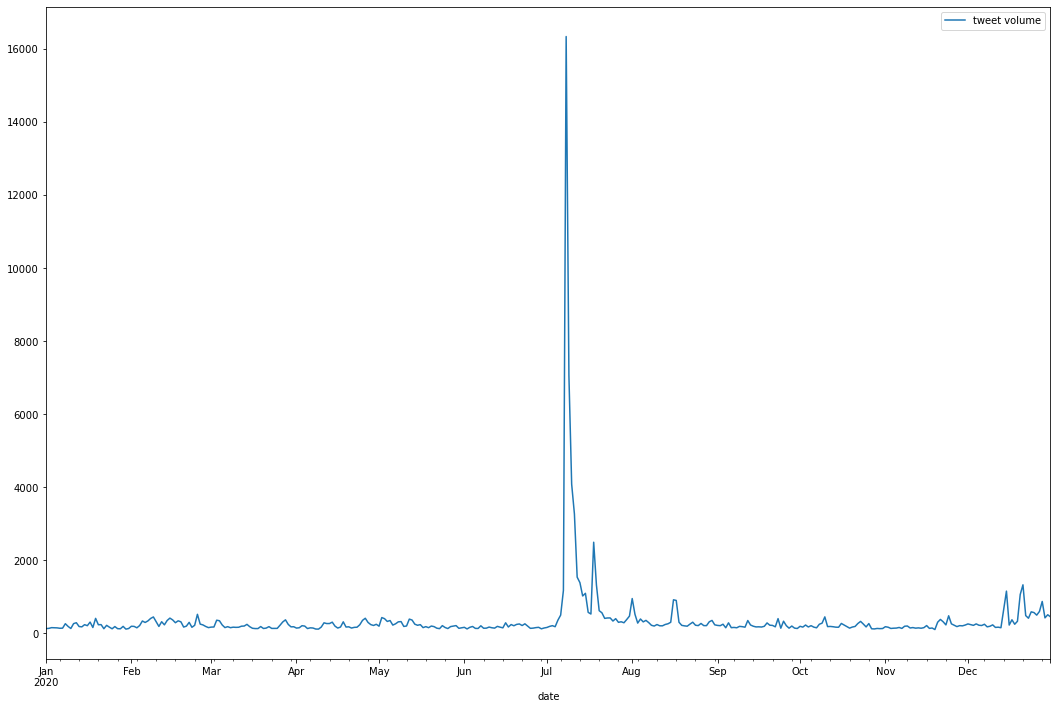

In [9]:
#Time series chart of tweet volume
tweet_volume=pd.Series(data['volume'])
tweet_volume.plot(figsize=(18,12),label='tweet volume')

plt.legend() 

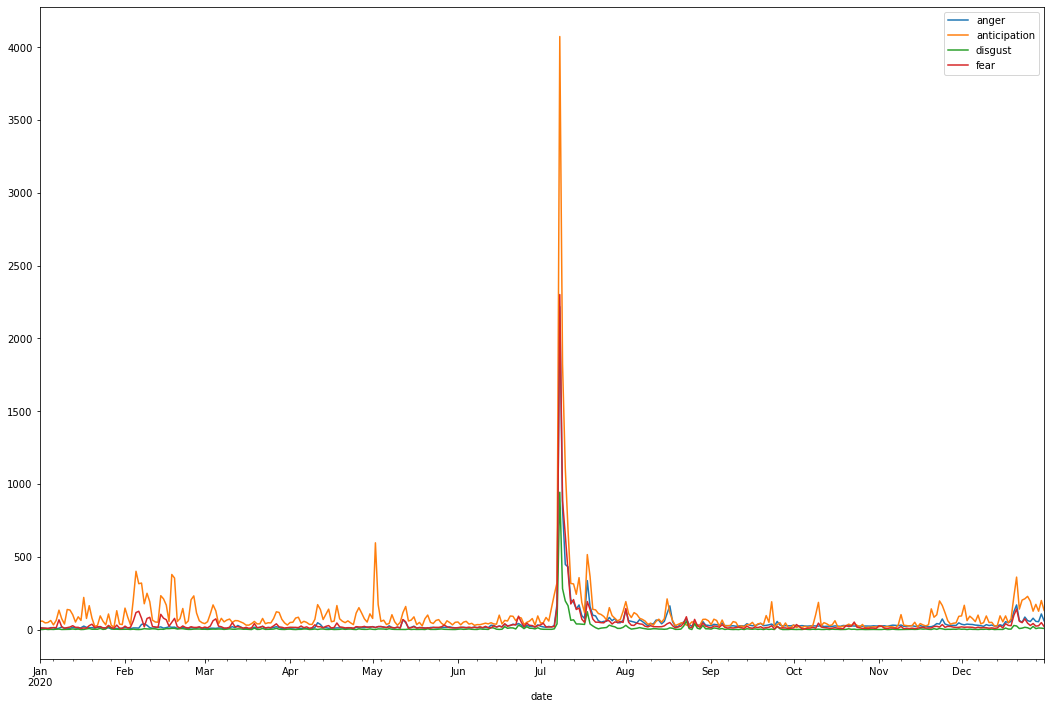

In [10]:
#Time series chart of some emotion scores
anger=pd.Series(data['anger_score'])
anger.plot(figsize=(18,12),label='anger')

anticipation=pd.Series(data['anticipation_score'])
anticipation.plot(figsize=(18,12),label='anticipation')

disgust=pd.Series(data['disgust_score'])
disgust.plot(figsize=(18,12),label='disgust')

fear=pd.Series(data['fear_score'])
fear.plot(figsize=(18,12),label='fear')

plt.legend() 

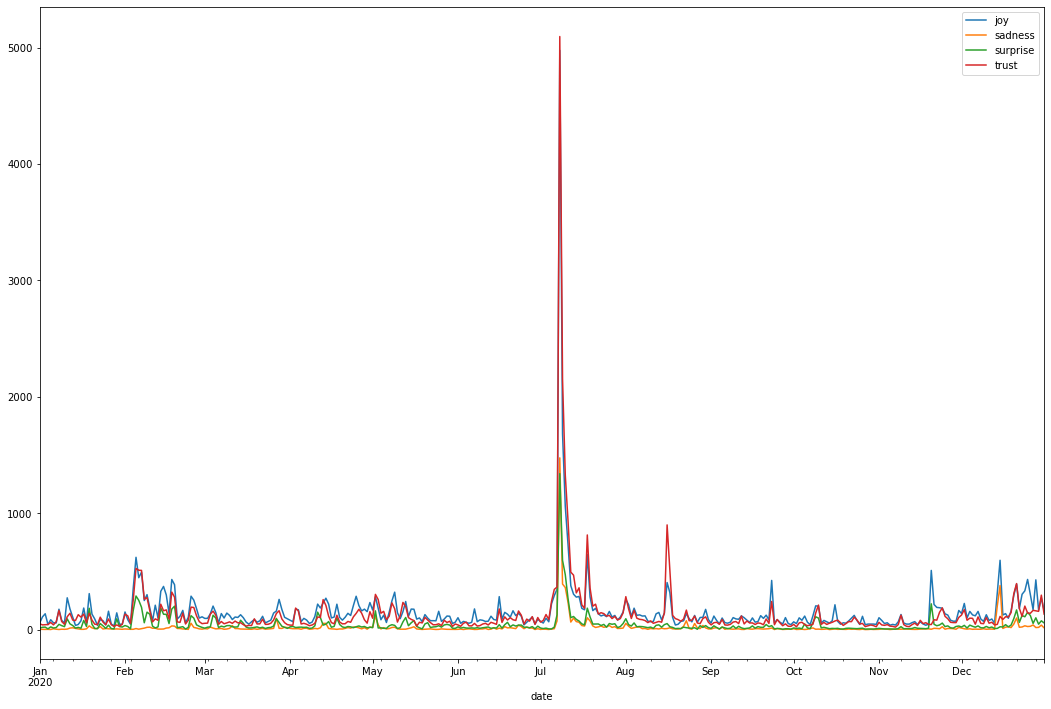

In [11]:
#Time series chart of some emotion scores
joy=pd.Series(data['joy_score'])
joy.plot(figsize=(18,12),label='joy')

sadness=pd.Series(data['sadness_score'])
sadness.plot(figsize=(18,12),label='sadness')

surprise=pd.Series(data['surprise_score'])
surprise.plot(figsize=(18,12),label='surprise')

trust=pd.Series(data['trust_score'])
trust.plot(figsize=(18,12),label='trust')

plt.legend() 

# Stationarity Test

In [12]:
#ADF test
#The null hypothesis is that the time series is not stationary. 
#If the p-value is less than the significance level, reject the null hypothesis.
def adfuller_test(series,signif=0.05):

    adftest = adfuller(series)
    
    adf_output = pd.Series(adftest[0:3], index=['Test Statistic','P-value','Lags Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
        
    #print ('Results of ADF Test:')
    #print(adf_output)
    
    return adf_output[1] < signif

In [13]:
#KPSS test
#The null hypothesis is that the time series is stationary. 
#If the p-value is less than the significance level, accept the null hypothesis.
def kpss_test(timeseries,signif=0.05):
    
    kpsstest = kpss(timeseries,nlags="auto")
    
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        
    #print ('Results of KPSS Test:')
    #print (kpss_output)
    
    return kpss_output[1] > signif

In [14]:
#Perform ADF and KPSS tests at the same time. 
#If the time series is not stable, perform first-order difference and continue to loop.
def difference(test_series):    
    
    #Difference order d
    d=0
    
    while True:
        
        adfuller_result=adfuller_test(test_series)
        kpss_result=kpss_test(test_series)
        
        if adfuller_result and kpss_result:
            break
        else:
            d+=1
            test_series = test_series.diff().dropna()
    
    print('Difference order:',d)
    
    return test_series

In [15]:
#The first-order difference on the price
price_diff=difference(price)

Difference order: 1


In [16]:
coin_volume_diff=difference(coin_volume)
 
#The first-order difference on the volume of coin
market_dominance_diff=difference(market_dominance)

Difference order: 0
Difference order: 1


In [17]:
tweet_volume_diff=difference(tweet_volume)

anger_diff=difference(anger)
anticipation_diff=difference(anticipation)
joy_diff=difference(joy)
surprise_diff=difference(surprise)
trust_diff=difference(trust)
disgust_diff=difference(disgust)
fear_diff=difference(fear)
sadness_diff=difference(sadness)

Difference order: 0
Difference order: 0
Difference order: 0
Difference order: 0
Difference order: 0
Difference order: 0
Difference order: 0
Difference order: 0
Difference order: 0


# Granger Causality Test

In [18]:
price_diff_ls=price_diff.tolist()

In [19]:
#There is a correlation
coin_volume_ls=coin_volume_diff.tolist()
coin_volume_ls=coin_volume_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,coin_volume_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2556 , p=0.0015  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=10.3408 , p=0.0013  , df=1
likelihood ratio test: chi2=10.1967 , p=0.0014  , df=1
parameter F test:         F=10.2556 , p=0.0015  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.7035  , p=0.0001  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=19.6780 , p=0.0001  , df=2
likelihood ratio test: chi2=19.1632 , p=0.0001  , df=2
parameter F test:         F=9.7031  , p=0.0001  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.5458 , p=0.0000  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=35.3205 , p=0.0000  , df=3
likelihood ratio test: chi2=33.7019 , p=0.0000  , df=3
parameter F test:         F=11.5459 , p=0.0000  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.1832  , p=0.0000  

{1: ({'ssr_ftest': (10.25560546022239, 0.0014837654608876626, 361.0, 1),
   'ssr_chi2test': (10.340832098395984, 0.0013011934108753784, 1),
   'lrtest': (10.196670321216516, 0.0014069446302506668, 1),
   'params_ftest': (10.255605460222371, 0.0014837654608876626, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (9.703476216860356, 7.872095108853526e-05, 358.0, 2),
   'ssr_chi2test': (19.677999255420723, 5.333063493163561e-05, 2),
   'lrtest': (19.163157788186254, 6.898793704447692e-05, 2),
   'params_ftest': (9.703094115163541, 7.87494889599655e-05, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (11.545847475407372, 3.073455252501395e-07, 355.0, 3),
   'ssr_chi2test': (35.32053622054199, 1.0423375007156375e-07, 3),
   'lrtest': (33.701888359305485, 2.290084267087948e-07, 3),
   'params_ftest': (11.545937596028628, 3.073087028980267e-07, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 

In [20]:
#There is a correlation
market_dominance_ls=market_dominance_diff.tolist()
market_dominance_ls=market_dominance_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,market_dominance_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7125  , p=0.1004  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=2.7351  , p=0.0982  , df=1
likelihood ratio test: chi2=2.7249  , p=0.0988  , df=1
parameter F test:         F=2.7125  , p=0.1004  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2187  , p=0.2968  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=2.4714  , p=0.2906  , df=2
likelihood ratio test: chi2=2.4631  , p=0.2918  , df=2
parameter F test:         F=1.2187  , p=0.2968  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0403  , p=0.1079  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=6.2416  , p=0.1004  , df=3
likelihood ratio test: chi2=6.1884  , p=0.1028  , df=3
parameter F test:         F=2.0403  , p=0.1079  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2038  , p=0.0133  

{1: ({'ssr_ftest': (2.7125438773085664, 0.10043227017005023, 361.0, 1),
   'ssr_chi2test': (2.735085793186477, 0.09816622936851448, 1),
   'lrtest': (2.7248612999683246, 0.0987967037204414, 1),
   'params_ftest': (2.71254387730857, 0.10043227017005023, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.2186966229716827, 0.2968386082497666, 358.0, 2),
   'ssr_chi2test': (2.471435051054306, 0.29062615585086976, 2),
   'lrtest': (2.463059832867657, 0.2918457363648737, 2),
   'params_ftest': (1.2186966229723204, 0.2968386082495766, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.0402982976902955, 0.10791169494257256, 355.0, 3),
   'ssr_chi2test': (6.241588595187777, 0.10043007899151005, 3),
   'lrtest': (6.188390613649062, 0.10279581309012846, 3),
   'params_ftest': (2.0402982976905513, 0.10791169494253729, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [21]:
#There is a correlation
tweet_volume_ls=tweet_volume_diff.tolist()
tweet_volume_ls=tweet_volume_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,tweet_volume_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6525 , p=0.0002  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=14.7742 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4823 , p=0.0001  , df=1
parameter F test:         F=14.6525 , p=0.0002  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5828  , p=0.0016  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=13.3494 , p=0.0013  , df=2
likelihood ratio test: chi2=13.1098 , p=0.0014  , df=2
parameter F test:         F=6.5828  , p=0.0016  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5130  , p=0.0001  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=22.9834 , p=0.0000  , df=3
likelihood ratio test: chi2=22.2833 , p=0.0001  , df=3
parameter F test:         F=7.5130  , p=0.0001  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.0760  , p=0.0000  

{1: ({'ssr_ftest': (14.652475159999076, 0.00015233622840064672, 361.0, 1),
   'ssr_chi2test': (14.774240881550314, 0.00012117957179710526, 1),
   'lrtest': (14.482282165732613, 0.00014148406635055929, 1),
   'params_ftest': (14.652475159999042, 0.00015233622840064916, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.582767789311585, 0.0015575917529672863, 358.0, 2),
   'ssr_chi2test': (13.349411773855337, 0.0012624438324819105, 2),
   'lrtest': (13.109804618441558, 0.0014231218860998715, 2),
   'params_ftest': (6.582767781786367, 0.0015575917642727376, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.51300581920214, 6.899129649640503e-05, 355.0, 3),
   'ssr_chi2test': (22.983448787756405, 4.070507936524321e-05, 3),
   'lrtest': (22.283319558197036, 5.694939489476392e-05, 3),
   'params_ftest': (7.513005811918883, 6.899129717630534e-05, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1

In [22]:
#There is a correlation
anger_ls=anger_diff.tolist()
anger_ls=anger_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,anger_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0001 , p=0.0002  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=14.1164 , p=0.0002  , df=1
likelihood ratio test: chi2=13.8496 , p=0.0002  , df=1
parameter F test:         F=14.0001 , p=0.0002  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.1805  , p=0.0003  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=16.5894 , p=0.0002  , df=2
likelihood ratio test: chi2=16.2215 , p=0.0003  , df=2
parameter F test:         F=8.1805  , p=0.0003  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.5296  , p=0.0000  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=26.0933 , p=0.0000  , df=3
likelihood ratio test: chi2=25.1958 , p=0.0000  , df=3
parameter F test:         F=8.5296  , p=0.0000  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.5581  , p=0.0000  

{1: ({'ssr_ftest': (14.000071316718959, 0.00021258199075194808, 361.0, 1),
   'ssr_chi2test': (14.116415399683381, 0.0001718376307345928, 1),
   'lrtest': (13.849565844815515, 0.0001980424869804758, 1),
   'params_ftest': (14.000071316718978, 0.00021258199075194808, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (8.180470419147042, 0.0003357815945100177, 358.0, 2),
   'ssr_chi2test': (16.589445598605455, 0.00024983176683003095, 2),
   'lrtest': (16.221536391766676, 0.0003002881044792326, 2),
   'params_ftest': (8.180470419801647, 0.00033578159429981135, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.529587420316252, 1.7472572197172732e-05, 355.0, 3),
   'ssr_chi2test': (26.093329404122393, 9.117764348593364e-06, 3),
   'lrtest': (25.195793163718918, 1.4051356513740086e-05, 3),
   'params_ftest': (8.529587421099048, 1.747257217872763e-05, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.

In [23]:
#There is a correlation
anticipation_ls=anticipation_diff.tolist()
anticipation_ls=anticipation_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,anticipation_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0050 , p=0.0010  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=11.0965 , p=0.0009  , df=1
likelihood ratio test: chi2=10.9307 , p=0.0009  , df=1
parameter F test:         F=11.0050 , p=0.0010  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1306  , p=0.0064  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=10.4045 , p=0.0055  , df=2
likelihood ratio test: chi2=10.2582 , p=0.0059  , df=2
parameter F test:         F=5.1306  , p=0.0064  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7648  , p=0.0007  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=17.6354 , p=0.0005  , df=3
likelihood ratio test: chi2=17.2193 , p=0.0006  , df=3
parameter F test:         F=5.7648  , p=0.0007  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5991  , p=0.0002  

{1: ({'ssr_ftest': (11.005039963902272, 0.0010010286411845425, 361.0, 1),
   'ssr_chi2test': (11.096494589641074, 0.0008649105016127818, 1),
   'lrtest': (10.93071766643152, 0.0009458285043641024, 1),
   'params_ftest': (11.005039963902252, 0.0010010286411845425, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.130591803207783, 0.006355470015832351, 358.0, 2),
   'ssr_chi2test': (10.404496226616901, 0.005504176488824259, 2),
   'lrtest': (10.25817602456118, 0.005921958765388717, 2),
   'params_ftest': (5.130591807047755, 0.006355469992107491, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.764800944012573, 0.0007375098113276152, 355.0, 3),
   'ssr_chi2test': (17.635419225908887, 0.0005229485136011483, 3),
   'lrtest': (17.21931092957493, 0.0006370046493545923, 3),
   'params_ftest': (5.764800943223704, 0.0007375098121166362, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.]

In [24]:
#There is a correlation
joy_ls=joy_diff.tolist()
joy_ls=joy_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,joy_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5886  , p=0.0062  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=7.6517  , p=0.0057  , df=1
likelihood ratio test: chi2=7.5724  , p=0.0059  , df=1
parameter F test:         F=7.5886  , p=0.0062  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9452  , p=0.0202  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=8.0007  , p=0.0183  , df=2
likelihood ratio test: chi2=7.9138  , p=0.0191  , df=2
parameter F test:         F=3.9452  , p=0.0202  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5170  , p=0.0040  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=13.8181 , p=0.0032  , df=3
likelihood ratio test: chi2=13.5609 , p=0.0036  , df=3
parameter F test:         F=4.5170  , p=0.0040  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6200  , p=0.0012  

{1: ({'ssr_ftest': (7.588609404508844, 0.006171361964516331, 361.0, 1),
   'ssr_chi2test': (7.651672640557394, 0.005671970751100978, 1),
   'lrtest': (7.572359014013273, 0.005927015981391194, 1),
   'params_ftest': (7.588609404508872, 0.006171361964516172, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.945246009340889, 0.020193451360930075, 358.0, 2),
   'ssr_chi2test': (8.000694421177332, 0.01830928060886875, 2),
   'lrtest': (7.913799334857686, 0.019122307998431787, 2),
   'params_ftest': (3.9452460121646764, 0.0201934513051377, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.51697542076398, 0.003998251449807856, 355.0, 3),
   'ssr_chi2test': (13.81812762521037, 0.003163461015959857, 3),
   'lrtest': (13.560922333166673, 0.0035680327151154808, 3),
   'params_ftest': (4.516975421067504, 0.0039982514481673795, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

In [25]:
#There is a correlation
surprise_ls=surprise_diff.tolist()
surprise_ls=surprise_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,surprise_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2452  , p=0.0074  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=7.3054  , p=0.0069  , df=1
likelihood ratio test: chi2=7.2330  , p=0.0072  , df=1
parameter F test:         F=7.2452  , p=0.0074  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4396  , p=0.0018  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=13.0590 , p=0.0015  , df=2
likelihood ratio test: chi2=12.8296 , p=0.0016  , df=2
parameter F test:         F=6.4396  , p=0.0018  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3830  , p=0.0003  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=19.5267 , p=0.0002  , df=3
likelihood ratio test: chi2=19.0183 , p=0.0003  , df=3
parameter F test:         F=6.3830  , p=0.0003  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.4947  , p=0.0003  

{1: ({'ssr_ftest': (7.245153259885626, 0.007440206524760776, 361.0, 1),
   'ssr_chi2test': (7.305362289746172, 0.0068749134077122865, 1),
   'lrtest': (7.23302047652578, 0.007157468464536921, 1),
   'params_ftest': (7.245153259885654, 0.007440206524760776, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (6.439550556433001, 0.0017884179698475654, 358.0, 2),
   'ssr_chi2test': (13.058976826732845, 0.0014597524486366338, 2),
   'lrtest': (12.829563481741388, 0.0016371771980154008, 2),
   'params_ftest': (6.439550556006769, 0.0017884179705833757, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.383039447208378, 0.0003188834663214081, 355.0, 3),
   'ssr_chi2test': (19.52670659061493, 0.00021272784242328723, 3),
   'lrtest': (19.01826390369115, 0.0002710318474378688, 3),
   'params_ftest': (6.383039448414956, 0.00031888346579967515, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],

In [26]:
#There is a correlation
trust_ls=trust_diff.tolist()
trust_ls=trust_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,trust_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3394 , p=0.0008  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=11.4336 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2577 , p=0.0008  , df=1
parameter F test:         F=11.3394 , p=0.0008  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5189  , p=0.0115  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=9.1641  , p=0.0102  , df=2
likelihood ratio test: chi2=9.0504  , p=0.0108  , df=2
parameter F test:         F=4.5189  , p=0.0115  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1802  , p=0.0016  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=15.8471 , p=0.0012  , df=3
likelihood ratio test: chi2=15.5101 , p=0.0014  , df=3
parameter F test:         F=5.1802  , p=0.0016  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3954  , p=0.0003  

{1: ({'ssr_ftest': (11.339371482996057, 0.0008405381338668557, 361.0, 1),
   'ssr_chi2test': (11.433604487009875, 0.0007212762645003169, 1),
   'lrtest': (11.25770791251307, 0.0007929306191589036, 1),
   'params_ftest': (11.339371482996127, 0.000840538133866834, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.518947065312341, 0.01152948392182014, 358.0, 2),
   'ssr_chi2test': (9.164121702281452, 0.010233784243544757, 2),
   'lrtest': (9.050355961031528, 0.010832786239968396, 2),
   'params_ftest': (4.5189470655320445, 0.01152948391934962, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.180229661388771, 0.0016291595748116321, 355.0, 3),
   'ssr_chi2test': (15.84712510498086, 0.0012188242993495233, 3),
   'lrtest': (15.510060520230581, 0.0014287955224094556, 3),
   'params_ftest': (5.180229662596264, 0.001629159572145899, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
  

In [27]:
#There is a correlation
disgust_ls=disgust_diff.tolist()
disgust_ls=disgust_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,disgust_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.9503 , p=0.0004  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=13.0580 , p=0.0003  , df=1
likelihood ratio test: chi2=12.8292 , p=0.0003  , df=1
parameter F test:         F=12.9503 , p=0.0004  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.7159  , p=0.0002  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=17.6752 , p=0.0001  , df=2
likelihood ratio test: chi2=17.2583 , p=0.0002  , df=2
parameter F test:         F=8.7159  , p=0.0002  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.2928  , p=0.0000  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=25.3690 , p=0.0000  , df=3
likelihood ratio test: chi2=24.5195 , p=0.0000  , df=3
parameter F test:         F=8.2928  , p=0.0000  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.2459  , p=0.0000  

{1: ({'ssr_ftest': (12.950346370565047, 0.00036450167545555936, 361.0, 1),
   'ssr_chi2test': (13.057966977522648, 0.0003019970595349033, 1),
   'lrtest': (12.829204225183275, 0.0003412508601313365, 1),
   'params_ftest': (12.950346370565056, 0.00036450167545555936, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (8.715853693310093, 0.00020138261848473362, 358.0, 2),
   'ssr_chi2test': (17.675166986991975, 0.00014517313497926663, 2),
   'lrtest': (17.258325755322403, 0.00017881427194995083, 2),
   'params_ftest': (8.715853693373706, 0.00020138261847252117, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.29280401549986, 2.404895567650307e-05, 355.0, 3),
   'ssr_chi2test': (25.36897228403619, 1.2926907762503224e-05, 3),
   'lrtest': (24.51950663588923, 1.945763344794932e-05, 3),
   'params_ftest': (8.292804015691713, 2.4048955670275674e-05, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.,

In [28]:
#There is a correlation
fear_ls=fear_diff.tolist()
fear_ls=fear_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,fear_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.3818 , p=0.0003  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=13.4930 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2489 , p=0.0003  , df=1
parameter F test:         F=13.3818 , p=0.0003  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4361  , p=0.0007  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=15.0799 , p=0.0005  , df=2
likelihood ratio test: chi2=14.7750 , p=0.0006  , df=2
parameter F test:         F=7.4361  , p=0.0007  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.6690  , p=0.0001  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=23.4608 , p=0.0000  , df=3
likelihood ratio test: chi2=22.7319 , p=0.0000  , df=3
parameter F test:         F=7.6690  , p=0.0001  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.8667  , p=0.0000  

{1: ({'ssr_ftest': (13.38179684135752, 0.0002919096176209783, 361.0, 1),
   'ssr_chi2test': (13.49300290929124, 0.0002394546827451374, 1),
   'lrtest': (13.248932256898115, 0.0002727351772867499, 1),
   'params_ftest': (13.38179684135757, 0.00029190961762096893, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.436071868928582, 0.0006852240194715687, 358.0, 2),
   'ssr_chi2test': (15.079855242575837, 0.0005314360850656657, 2),
   'lrtest': (14.775042456375559, 0.0006189282355002582, 2),
   'params_ftest': (7.436071866609454, 0.0006852240209973082, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.669040462325918, 5.586275284206822e-05, 355.0, 3),
   'ssr_chi2test': (23.460782935453373, 3.2368176670138153e-05, 3),
   'lrtest': (22.731878912556567, 4.59274375550218e-05, 3),
   'params_ftest': (7.669040462299115, 5.586275284409375e-05, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0.

In [29]:
#There is a correlation
sadness_ls=sadness_diff.tolist()
sadness_ls=sadness_ls[-len(price_diff_ls):]

grangercausalitytests(list(zip(price_diff_ls,sadness_ls)), maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1216  , p=0.0027  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=9.1974  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0831  , p=0.0026  , df=1
parameter F test:         F=9.1216  , p=0.0027  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9359  , p=0.0029  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=12.0377 , p=0.0024  , df=2
likelihood ratio test: chi2=11.8424 , p=0.0027  , df=2
parameter F test:         F=5.9359  , p=0.0029  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3087  , p=0.0004  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=19.2993 , p=0.0002  , df=3
likelihood ratio test: chi2=18.8024 , p=0.0003  , df=3
parameter F test:         F=6.3087  , p=0.0004  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.7555  , p=0.0002  

{1: ({'ssr_ftest': (9.121597726592341, 0.0027059778221767, 361.0, 1),
   'ssr_chi2test': (9.19740047778286, 0.0024235905555515195, 1),
   'lrtest': (9.08312343796024, 0.0025797906118411153, 1),
   'params_ftest': (9.121597726592325, 0.0027059778221767, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.9359439276079, 0.002909877971461919, 358.0, 2),
   'ssr_chi2test': (12.037696344813787, 0.002432469767854858, 2),
   'lrtest': (11.842406816965195, 0.0026819707278463666, 2),
   'params_ftest': (5.935943927897328, 0.00290987797064668, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (6.308700567595403, 0.00035270510389725693, 355.0, 3),
   'ssr_chi2test': (19.29929244058762, 0.00023707811380081428, 3),
   'lrtest': (18.802424577676902, 0.0003003575981994689, 3),
   'params_ftest': (6.308700565939655, 0.0003527051046891938, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
        

# Determine Series Lag

In [30]:
#The optimal lag of coin_volume is 2 days
coin_volume_model = VAR(list(zip(price_diff_ls,coin_volume_ls)))
result = coin_volume_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,19.24,19.26,2.262e+08,19.25
1,18.50,18.56,1.081e+08,18.52
2,18.31,18.42*,8.968e+07,18.35
3,18.28,18.43,8.686e+07,18.34*
4,18.28,18.47,8.666e+07,18.36
5,18.27*,18.51,8.588e+07*,18.36
6,18.28,18.57,8.721e+07,18.40
7,18.30,18.63,8.869e+07,18.43


In [31]:
#The optimal lag of tweet_volume is 2 days
tweet_volume_model = VAR(list(zip(price_diff_ls,tweet_volume_ls)))
result = tweet_volume_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-3.718,-3.696,0.02429,-3.709
1,-4.271,-4.206,0.01397,-4.245
2,-4.396,-4.288*,0.01232,-4.353*
3,-4.409*,-4.257,0.01217*,-4.348
4,-4.408,-4.213,0.01218,-4.331
5,-4.402,-4.163,0.01226,-4.307
6,-4.385,-4.103,0.01247,-4.273
7,-4.370,-4.045,0.01265,-4.241


In [32]:
#The optimal lag of anger_score is 2 days
anger_model = VAR(list(zip(price_diff_ls,anger_ls)))
result = anger_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-7.776,-7.754,0.0004197,-7.767
1,-8.262,-8.197,0.0002582,-8.236
2,-8.393,-8.285*,0.0002264,-8.350
3,-8.412,-8.260,0.0002222,-8.351*
4,-8.413*,-8.218,0.0002219*,-8.336
5,-8.406,-8.167,0.0002236,-8.311
6,-8.389,-8.107,0.0002275,-8.277
7,-8.375,-8.050,0.0002306,-8.245


In [33]:
#The optimal lag of anticipation_score is 2 days
anticipation_model = VAR(list(zip(price_diff_ls,anticipation_ls)))
result = anticipation_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-6.435,-6.413,0.001604,-6.427
1,-6.966,-6.900,0.0009439,-6.940
2,-7.102,-6.994*,0.0008234,-7.059*
3,-7.105*,-6.953,0.0008209*,-7.045
4,-7.103,-6.907,0.0008230,-7.025
5,-7.102,-6.863,0.0008238,-7.007
6,-7.085,-6.803,0.0008380,-6.973
7,-7.072,-6.747,0.0008486,-6.943


In [34]:
#The optimal lag of joy_score is 2 days
joy_model = VAR(list(zip(price_diff_ls,joy_ls)))
result = joy_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-6.170,-6.148,0.002091,-6.161
1,-6.486,-6.421,0.001525,-6.460
2,-6.626,-6.517*,0.001326,-6.583*
3,-6.627*,-6.475,0.001324*,-6.567
4,-6.620,-6.425,0.001333,-6.542
5,-6.617,-6.379,0.001337,-6.522
6,-6.600,-6.318,0.001361,-6.488
7,-6.588,-6.263,0.001377,-6.459


In [35]:
#The optimal lag of surprise_score is 2 days
surprise_model = VAR(list(zip(price_diff_ls,surprise_ls)))
result = surprise_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-8.458,-8.437,0.0002121,-8.450
1,-8.950,-8.884,0.0001298,-8.924
2,-9.097*,-8.989*,0.0001120*,-9.054*
3,-9.094,-8.942,0.0001123,-9.034
4,-9.082,-8.887,0.0001136,-9.005
5,-9.095,-8.856,0.0001122,-9.000
6,-9.077,-8.795,0.0001143,-8.965
7,-9.061,-8.736,0.0001161,-8.932


In [36]:
#The optimal lag of trust_score is 2 days
trust_model = VAR(list(zip(price_diff_ls,trust_ls)))
result = trust_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-6.010,-5.989,0.002454,-6.002
1,-6.515,-6.450,0.001482,-6.489
2,-6.651,-6.543*,0.001292,-6.608*
3,-6.656*,-6.504,0.001286*,-6.596
4,-6.656,-6.460,0.001287,-6.578
5,-6.652,-6.414,0.001291,-6.557
6,-6.634,-6.353,0.001314,-6.522
7,-6.621,-6.296,0.001332,-6.492


In [37]:
#The optimal lag of fear_score is 2 days
fear_model = VAR(list(zip(price_diff_ls,fear_ls)))
result = fear_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-7.648,-7.627,0.0004769,-7.640
1,-8.117,-8.052,0.0002983,-8.091
2,-8.285,-8.176*,0.0002524,-8.241*
3,-8.290*,-8.138,0.0002510*,-8.230
4,-8.289,-8.094,0.0002513,-8.211
5,-8.289,-8.051,0.0002512,-8.195
6,-8.273,-7.992,0.0002552,-8.161
7,-8.256,-7.931,0.0002598,-8.126


In [38]:
#The optimal lag of disgust_score is 2 days
disgust_model = VAR(list(zip(price_diff_ls,disgust_ls)))
result = disgust_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-9.536,-9.514,7.222e-05,-9.527
1,-9.849,-9.784,5.280e-05,-9.823
2,-10.02,-9.915*,4.435e-05,-9.980*
3,-10.04*,-9.885,4.375e-05*,-9.977
4,-10.03,-9.840,4.384e-05,-9.957
5,-10.03,-9.789,4.415e-05,-9.933
6,-10.01,-9.729,4.490e-05,-9.899
7,-9.994,-9.669,4.567e-05,-9.865


In [39]:
#The optimal lag of sadness_score is 2 days
sadness_model = VAR(list(zip(price_diff_ls,sadness_ls)))
result = sadness_model.select_order(maxlags=7)
result.summary()

,AIC,BIC,FPE,HQIC
0,-8.570,-8.548,0.0001897,-8.562
1,-8.813,-8.748,0.0001487,-8.788
2,-8.978,-8.870*,0.0001262,-8.935*
3,-8.982*,-8.831,0.0001256*,-8.922
4,-8.975,-8.780,0.0001265,-8.898
5,-8.964,-8.726,0.0001279,-8.869
6,-8.946,-8.664,0.0001303,-8.834
7,-8.938,-8.613,0.0001313,-8.809


# LSTM Model

In [40]:
#Prepare lstm data
price_1=price_diff.reset_index(drop=False)

market_dominance_1=market_dominance_diff.shift(periods=4)
market_dominance_1=market_dominance_1.reset_index(drop=False)

lstm_data=data.drop(['close_price','market_dominance','available_volume'],axis=1)

lstm_data=lstm_data.shift(periods=2)
lstm_data=lstm_data.reset_index(drop=False)

temp=pd.merge(price_1,market_dominance_1,on='date',how='outer')
temp=pd.merge(temp,lstm_data,on='date',how='outer')

temp.index = temp['date']
temp=temp.sort_index()
del temp['date']

temp=temp.dropna()

temp.rename(columns={"volume_24h":"coin_volume","close_price":"price","volume":"tweet_volume"},inplace=True)
lstm_data=temp[['price','coin_volume','market_dominance','tweet_volume','anger_score','anticipation_score','surprise_score','joy_score','disgust_score','fear_score','trust_score','sadness_score']]

In [41]:
#Data normalization
columns = ['coin_volume','market_dominance','tweet_volume','anger_score','anticipation_score','surprise_score','joy_score','disgust_score','fear_score','trust_score','sadness_score']

for col in columns:
    scaler = MinMaxScaler()
    lstm_data[col] = scaler.fit_transform(lstm_data[col].values.reshape(-1,1))
    
price_scaler=MinMaxScaler()
lstm_data['price']=price_scaler.fit_transform(lstm_data['price'].values.reshape(-1,1))

In [42]:
#Time series nested cross validation
def splitdata(lstm_data,n_splits):
    
    trainTestSplit = TimeSeriesSplit(n_splits+1).split(lstm_data)
    next(trainTestSplit) #Skip the first fold
    
    Xtrain_ls=[]
    ytrain_ls=[]
    Xval_ls=[]
    yval_ls=[]
    Xtest_ls=[]
    ytest_ls=[]
    
    for trainValIndices, testIndices in trainTestSplit:
        
        XTrainVal , yTrainVal = lstm_data.iloc[trainValIndices,1:] , lstm_data.iloc[trainValIndices,0]
        XTest, yTest = lstm_data.iloc[testIndices,1:] , lstm_data.iloc[testIndices,0]
        testLength = len(XTest)
        
        XVal=XTrainVal.iloc[-testLength:-1]
        yVal=yTrainVal.iloc[-testLength:-1]
        
        XTrain=XTrainVal.iloc[:-testLength-1]
        yTrain=yTrainVal.iloc[:-testLength-1]       
        
        Xtrain_ls.append(XTrain)
        ytrain_ls.append(yTrain)
        Xval_ls.append(XVal)
        yval_ls.append(yVal)
        Xtest_ls.append(XTest)
        ytest_ls.append(yTest)
        
    return    Xtrain_ls,ytrain_ls,Xval_ls,yval_ls,Xtest_ls,ytest_ls
    

In [43]:
#Multivariate Vanilla LSTM
def fit_MVL_model(X,y,valX,valy,hidden_nodes,epoch,batch):
    model = Sequential()
    model.add(LSTM(hidden_nodes,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
        
    # fit network
    history = model.fit(X, y, epochs=epoch, batch_size=batch, validation_data=(valX, valy), verbose=0, shuffle=False)
    
    #plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    return model

In [44]:
#Multivariate Stacked LSTM
def fit_MSL_model(X,y,valX,valy,hidden_nodes_1,hidden_nodes_2,epoch,batch):
    model = Sequential()
    model.add(LSTM(hidden_nodes_1, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_nodes_2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
        
    # fit network
    history = model.fit(X, y, epochs=epoch, batch_size=batch, validation_data=(valX, valy), verbose=0, shuffle=False)
    
    #plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    return model

In [45]:
#Inverse price difference
def inverse_diff(i,prdicted_y):
    
    restore=ytest_ls[i].reset_index(drop=False)
    
    for i,j in enumerate(prdicted_y):
        restore.loc[i,'price']=j
    
    price_order_0=data['close_price']
    price_order_1=price_order_0.diff()

    a=price_order_0.reset_index(drop=False)
    a.rename(columns={'close_price':'true'},inplace=True)
    b=price_order_1.reset_index(drop=False)
    b.rename(columns={'close_price':'order1'},inplace=True)
    c=pd.merge(a,b,on='date',how='outer')
    restore=pd.merge(c,restore,on='date',how='outer')
    
    restore['1']=restore['order1'].shift(periods=1)
    restore['0']=restore['true'].shift(periods=1)
    
    restore=restore.dropna()
    
    restore['predicted'] = restore['price']+restore['1']+restore['0']
    restore.index = restore['date']
    
    return restore['true'],restore['predicted'],restore

In [46]:
#Trend prediction accuracy
def trend_accuracy(df):
    df['ture_trend']=df['true'].diff()
    df['pre_trend']=df['predicted'].diff()
    
    df.loc[df['ture_trend'] > 0,['ture_trend'] ]= 1
    df.loc[df['ture_trend'] < 0,['ture_trend'] ] = -1
    df.loc[df['ture_trend'] == 0,['ture_trend'] ] = 0
    df.loc[df['pre_trend'] > 0,['pre_trend'] ]= 1
    df.loc[df['pre_trend'] < 0,['pre_trend'] ] = -1
    df.loc[df['pre_trend'] == 0,['pre_trend'] ] = 0
    
    acc=0
    for i in range(len(df)):
        if df['ture_trend'][i]!=df['pre_trend'][i]:
            acc+=1
    
    ac=(len(df)-1-acc)/(len(df)-1)
    
    return ac

In [50]:
#Feature combination
fc=lstm_data.drop(['market_dominance', 'tweet_volume', 'anger_score','disgust_score','sadness_score','anticipation_score','fear_score'],axis=1)

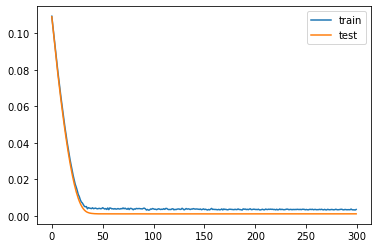

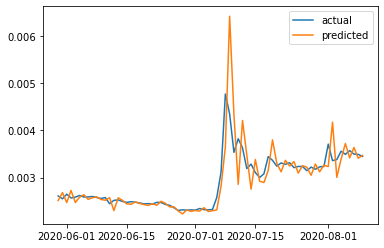

Test 1 RMSE: 0.000


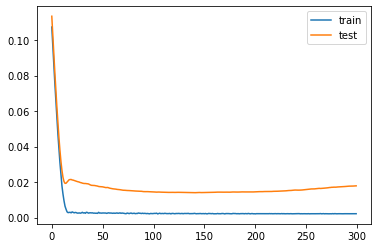

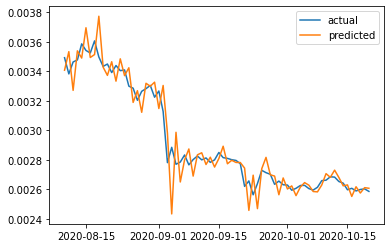

Test 2 RMSE: 0.000


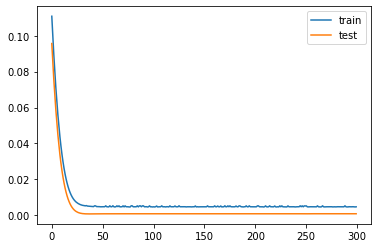

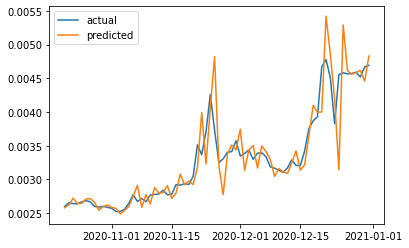

Test 3 RMSE: 0.000
Trend accuracy: 0.5352112676056338
Average RMSE: 0.00026104160906785404


In [57]:
#Number of nested cross validations
loop=3

#Split data
Xtrain_ls,ytrain_ls,Xval_ls,yval_ls,Xtest_ls,ytest_ls=splitdata(fc,loop)

#Store the RMSE returned each time
rmse_result=[]

for i in range(loop):
    #Get input value
    train_X=Xtrain_ls[i].values
    train_y=ytrain_ls[i].values
    val_X=Xval_ls[i].values
    val_y=yval_ls[i].values
    test_X=Xtest_ls[i].values
    test_y=ytest_ls[i].values
    
    #Reshape input
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    #Fit model
    model=fit_MSL_model(train_X,train_y,val_X,val_y,4,3,300,12)
    predicted_y = model.predict(test_X)
    
    #Inverse normalization
    predicted_y = price_scaler.inverse_transform(predicted_y)
    
    #Inverse difference
    actual_price,predicted_price,restore_price=inverse_diff(i,predicted_y)
    
    #Plot the forecast result
    plt.plot(actual_price, label='actual')
    plt.plot(predicted_price, label='predicted')
    plt.legend()
    plt.show()
    
    rmse = sqrt(mean_squared_error(actual_price,predicted_price))
    rmse_result.append(rmse)
    print('Test',i+1,'RMSE: %.3f' % rmse)

#Trend accuracy
trend = trend_accuracy(restore_price)
print('Trend accuracy:',trend)    

#Average RMSE
average_rmse=(rmse_result[0]+rmse_result[1]+rmse_result[2])/3
print('Average RMSE:',average_rmse)

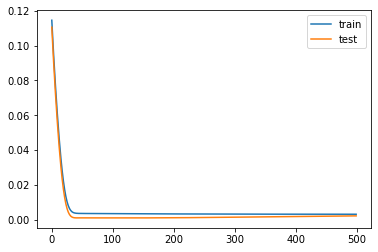

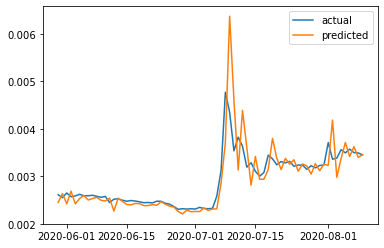

Test 1 RMSE: 0.000


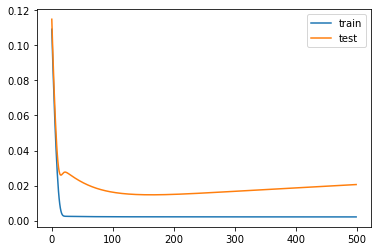

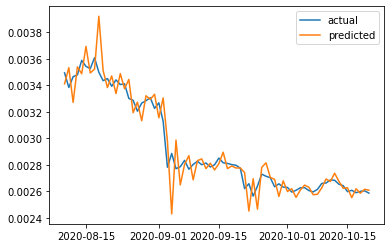

Test 2 RMSE: 0.000


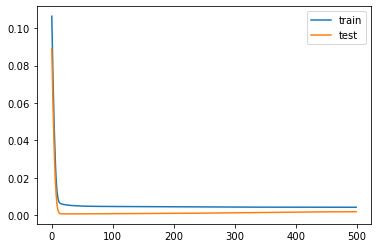

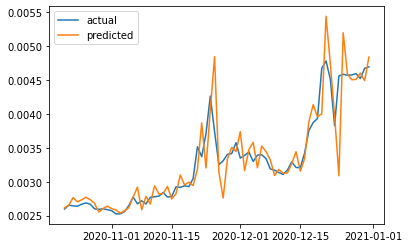

Test 3 RMSE: 0.000
Trend accuracy: 0.5633802816901409
Average RMSE: 0.0002631807576501712


In [56]:
#Number of nested cross validations
loop=3

#Split data
Xtrain_ls,ytrain_ls,Xval_ls,yval_ls,Xtest_ls,ytest_ls=splitdata(fc,loop)

#Store the RMSE returned each time
rmse_result=[]

for i in range(loop):
    #Get input value
    train_X=Xtrain_ls[i].values
    train_y=ytrain_ls[i].values
    val_X=Xval_ls[i].values
    val_y=yval_ls[i].values
    test_X=Xtest_ls[i].values
    test_y=ytest_ls[i].values
    
    #Reshape input
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    #Fit model
    model=fit_MVL_model(train_X,train_y,val_X,val_y,4,500,12)
    predicted_y = model.predict(test_X)
    
    #Inverse normalization
    predicted_y = price_scaler.inverse_transform(predicted_y)
    
    #Inverse difference
    actual_price,predicted_price,restore_price=inverse_diff(i,predicted_y)
    
    #Plot the forecast result
    plt.plot(actual_price, label='actual')
    plt.plot(predicted_price, label='predicted')
    plt.legend()
    plt.show()
    
    rmse = sqrt(mean_squared_error(actual_price,predicted_price))
    rmse_result.append(rmse)
    print('Test',i+1,'RMSE: %.3f' % rmse)

#Trend accuracy
trend = trend_accuracy(restore_price)
print('Trend accuracy:',trend)    

#Average RMSE
average_rmse=(rmse_result[0]+rmse_result[1]+rmse_result[2])/3
print('Average RMSE:',average_rmse)